# Map Classification
Ths notebook is about the use of machine learning algorithms for land cover classification. Being able to classify objects is one of the main task of intelligent behavior. In case of satellite images the task is to classify each pixel according to a set of predetermined classes such as forested, urban, water, crop field, pasture, desert, snow, and so on. There are two approaches to the classification task. One doen't use examples and the algorithms follows rules to classify each pixels in an image according to some attributes of the pixels. These methods are called unsupervised classification. The other approach makes use of examples to improve a classification algorithm. These methods are called supervised classification.

In [1]:
import numpy as np
import spectral
from osgeo import gdal, osr, ogr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print("GDAL version: %s"%gdal.__version__)
print("Spectral version: %s"%spectral.__version__)

GDAL version: 3.5.1
Spectral version: 0.23.1


## Unsupervised classification
We will use k-means clustering as an example of unsupervised algorithm. For this example we will use the data from the Landsat imagery used in the Southwest Regional Gap Analysis Project ([SWReGAP](https://swregap.org/)) and the [Spectral Python](https://www.spectralpython.net/) package that implements the k-means clustering algorithm. 

In [2]:
def stack_bands(filenames):
    """Returns a 3D array containing all band data from all files."""
    bands = []
    for fn in filenames:
        ds = gdal.Open(fn)
        for i in range(1, ds.RasterCount + 1):
            bands.append(ds.GetRasterBand(i).ReadAsArray())
    return np.dstack(bands)

In [3]:
raster_rgb_fn = 'data/raster/Landsat/Utah/LE70380322000181EDC02_60m.tif'
raster_tir_fn = 'data/raster/Landsat/Utah/LE70380322000181EDC02_TIR_60m.tif'
out_fn = 'data/raster/Landsat/Utah/kmeans_prediction_60m2.tif'

We plot the Thermal Infrared (TIF) band

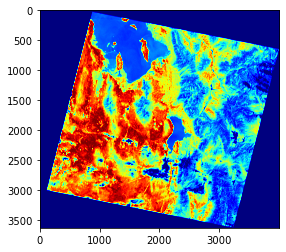

In [4]:
bands = stack_bands([raster_rgb_fn, raster_tir_fn])
plt.imshow(bands[:,:,3], cmap='jet')

We apply the k-means clustering algorithm to classify the pixels in the input image. The algorithms will classify each pixel in one out of nine classes (clusters)

In [7]:
classes_data, centers = spectral.kmeans(bands)

spectral:INFO: k-means iteration 1 - 9903429 pixels reassigned.
spectral:INFO: k-means iteration 2 - 2151944 pixels reassigned.
spectral:INFO: k-means iteration 3 - 867849 pixels reassigned.
spectral:INFO: k-means iteration 4 - 547027 pixels reassigned.
spectral:INFO: k-means iteration 5 - 325501 pixels reassigned.
spectral:INFO: k-means iteration 6 - 214849 pixels reassigned.
spectral:INFO: k-means iteration 7 - 174003 pixels reassigned.
spectral:INFO: k-means iteration 8 - 147331 pixels reassigned.
spectral:INFO: k-means iteration 9 - 139681 pixels reassigned.
spectral:INFO: k-means iteration 10 - 132859 pixels reassigned.
spectral:INFO: k-means iteration 11 - 123494 pixels reassigned.
spectral:INFO: k-means iteration 12 - 113834 pixels reassigned.
spectral:INFO: k-means iteration 13 - 105887 pixels reassigned.
spectral:INFO: k-means iteration 14 - 102579 pixels reassigned.
spectral:INFO: k-means iteration 15 - 105211 pixels reassigned.
spectral:INFO: k-means iteration 16 - 113352 pi

We import a function to create a raster file from a NumPy array that we have defined and used in another notebook and copied in the Python module geosciencelib.py

In [8]:
import geosciencelib as glib

In [9]:
ds = gdal.Open(raster_rgb_fn)
driver = gdal.GetDriverByName('GTiff')
out_ds = glib.make_raster(driver, ds, out_fn, classes_data, gdal.GDT_Byte)

In [10]:
out_ds.BuildOverviews('NEAREST', [2, 4, 8, 16, 32, 64, 128, 256])
out_ds.FlushCache()

We compute some statistics

In [11]:
stats = out_ds.GetRasterBand(1).ComputeStatistics(False)
print('Min. value: {0:.0f}, Max. value: {1:.0f}, Mean value: {2:.0f}'.format(stats[0], stats[1], stats[2]))

Min. value: 0, Max. value: 8, Mean value: 3


In [12]:
out_band = out_ds.GetRasterBand(1)
out_data = out_band.ReadAsArray()

Finally we plot the land cover map using nine colors, one for each class.

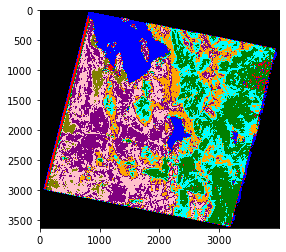

In [13]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'blue', 'red', 'green', 'cyan', 'orange', 'purple', 'pink', 'olive'])
plt.imshow(out_data, cmap=cmap)

## Supervised classification
A supervised classification task requires a model and a set of examples with labels from which the model parameters can be set to a value and pixels in future images will be correctly classified according to the examples. We will use decision tree as a model.

In [14]:
import csv
from sklearn import tree

In [16]:
train_fn = 'data/raster/Landsat/Utah/training_data.csv'
out_fn = 'data/raster/Landsat/Utah/tree_prediction60.tif'
gap_fn = 'data/raster/Landsat/Utah/landcover60.tif'

Read coordinates and class from csv

In [37]:
xys = []
classes = []
with open(train_fn) as fp:
    reader = csv.reader(fp)
    next(reader)
    for row in reader:
        xys.append([float(n) for n in row[:2]])
        classes.append(int(row[2]))

Get pixel offsets

In [38]:
ds = gdal.Open(raster_rgb_fn)
pixel_trans = gdal.Transformer(ds, None, [])
offset, ok = pixel_trans.TransformPoints(True, xys)
cols, rows, z = zip(*offset)

In [39]:
data = stack_bands([raster_rgb_fn, raster_tir_fn])

In [62]:
data.shape

(3631, 3996, 4)

Sample satellite data at pixel offsets

In [44]:
cols_int = [int(col) for col in cols]
rows_int = [int(row) for row in rows]

In [55]:
sample = data[rows_int, cols_int]

In [57]:
sample.shape

(578, 4)

We train the decision tree using the entire training set. This is not the correct procedure since we should use some example, e.g. 20-30%, to validate the model. We train a decision tree with at most 5 levels.

In [67]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(sample, classes)

In [68]:
rows, cols, bands = data.shape
data2d = np.reshape(data, (rows * cols, bands))
prediction = clf.predict(data2d)
prediction = np.reshape(prediction, (rows, cols))

In [69]:
prediction.shape

(3631, 3996)

We save the result on a raster file

In [73]:
dtree_prediction_fn = 'data/raster/Landsat/Utah/dtree_prediction.tif'
ds = gdal.Open(raster_rgb_fn)
driver = gdal.GetDriverByName('GTiff')
dtree_ds = glib.make_raster(driver, ds, dtree_prediction_fn, prediction, gdal.GDT_Byte)
dtree_ds.FlushCache()

We compute the usual statistics from which we can see that the result is different from what we get with the k-means clustering algorithm.

In [74]:
stats = dtree_ds.GetRasterBand(1).ComputeStatistics(False)
print('Min. value: {0:.0f}, Max. value: {1:.0f}, Mean value: {2:.0f}'.format(stats[0], stats[1], stats[2]))

Min. value: 2, Max. value: 121, Mean value: 40


We plot the data from which we can confirm that the result must be improved.

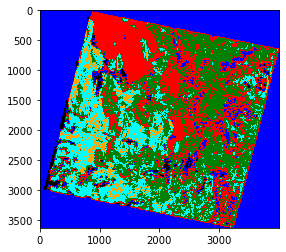

In [70]:
plt.imshow(prediction, cmap=cmap)

In [80]:
del dtree_ds, ds

## Accuracy assessment

In [5]:
from sklearn import metrics
import skll
import csv

In [18]:
accuracy_fn = 'data/raster/Landsat/Utah/accuracy_data.csv'
matrix_fn = 'data/raster/Landsat/Utah/confusion_matrix.csv'

In [7]:
xys = []
classes = []
with open(accuracy_fn) as fp:
    reader = csv.reader(fp)
    next(reader)
    for row in reader:
        xys.append([float(n) for n in row[:2]])
        classes.append(int(row[2]))
len(classes)

188

In [9]:
dtree_prediction_fn = 'data/raster/Landsat/Utah/dtree_prediction.tif'
ds = gdal.Open(dtree_prediction_fn)
pixel_trans = gdal.Transformer(ds, None, [])
offset, ok = pixel_trans.TransformPoints(True, xys)
cols, rows, z = zip(*offset)

In [10]:
cols_int = [int(col) for col in cols]
rows_int = [int(row) for row in rows]

In [11]:
data = ds.GetRasterBand(1).ReadAsArray()
sample = data[rows_int, cols_int]
del ds

In [12]:
sample.shape

(188,)

In [13]:
print('Kappa:', skll.kappa(classes, sample))

Kappa: 0.24422110552763832


In [14]:
labels = np.unique(np.concatenate((classes, sample)))
len(labels)

34

In [24]:
test_labels = np.array(labels[:33])
test_labels.shape

(33,)

In [17]:
matrix = metrics.confusion_matrix(classes, sample, labels=classes)

In [26]:
matrix.shape

(188, 188)

In [27]:
#matrix = np.insert(matrix, 0, test_labels, 0)
#matrix = np.insert(matrix, 0, np.insert(labels, 0, 0), 1)
np.savetxt(matrix_fn, matrix, fmt='%1.0f', delimiter=',')

## References